In [1]:
%cd ..

/home/lparolari/Projects/weakvg++


# Dataset

In [2]:
split = "val"
checkpoint = "output/model.ckpt"

Setup required stuff an initialize dataset and model.

In [5]:
import argparse
import logging
from math import ceil

import cv2
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from torch.utils.data import DataLoader

from weakvg.dataset import Flickr30kDataset, NormalizeCoord, collate_fn
from weakvg.model import MyModel
from weakvg.wordvec import get_nlp, get_objects_vocab, get_tokenizer, get_wordvec

vocab = None
font_size = 14
text_props = dict(facecolor="blue", alpha=0.5)

mpl.rcParams["figure.dpi"] = 100

tokenizer = get_tokenizer()
wordvec, vocab = get_wordvec(custom_tokens=get_objects_vocab())
nlp = get_nlp()

dataset = Flickr30kDataset(
    split=split,
    data_dir="data/flickr30k",
    tokenizer=tokenizer,
    vocab=vocab,
    nlp=nlp,
    transform=NormalizeCoord(),
)

dataloader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=1,
    shuffle=False,
    pin_memory=True,
    drop_last=True,
    collate_fn=collate_fn,
)

In [29]:
try:
    model = MyModel.load_from_checkpoint(checkpoint, wordvec=wordvec, vocab=vocab)
except RuntimeError:
    print("Loading state dict from checkpoint...")
    import torch

    map_location = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    state_dict = torch.load(checkpoint, map_location=map_location)

    state_dict["state_dict"].pop("we.embedding.weight")
    
    omega = state_dict["hyper_parameters"]["omega"]
    neg_selection = state_dict["hyper_parameters"]["neg_selection"]
    
    model = MyModel(wordvec, vocab, omega=omega, neg_selection=neg_selection)
    
    model.load_state_dict(state_dict["state_dict"])

Loading state dict from checkpoint...


Just a sanity check

In [30]:
dataset.print_statistics()

Flickr30k (val)
Number of images-sentences pairs: 1000
Number of samples: 4986
Upperbound accuracy: 86.57


In [31]:
model.hparams_initial

"neg_selection": textual_sim_max
"omega":         0.4

Some util functions

In [62]:
def unbatch(x):
    return x[0].cpu().numpy()


def get_image(identifier):
    path = f"data/flickr30k/flickr30k_images/{identifier}.jpg"

    im = cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    return im


def txt(tokens):
    return " ".join(vocab.lookup_tokens([t for t in tokens if t != 0]))


def draw_box(ax, box, color, label=None, dashed=False):
    x1, y1 = box[0], box[1]
    x2, y2 = box[2], box[3]
    xy = (x1, y1)
    width, height = x2 - x1, y2 - y1

    rect = patches.Rectangle(
        xy,
        width,
        height,
        linewidth=2,
        edgecolor=[*color, 1.0],
        facecolor=[*color, 0.2],
        linestyle="--" if dashed else "-",
    )
    ax.add_patch(rect)

    if label is not None:
        ax.text(
            x1,
            y1,
            label,
            bbox={"facecolor": [*color, 1.0], "edgecolor": [*color, 0.0], "pad": 1.0},
            fontsize=font_size,
            color="black",
        )


def iou(box_a, box_b):
    x1 = max(box_a[0], box_b[0])
    y1 = max(box_a[1], box_b[1])
    x2 = min(box_a[2], box_b[2])
    y2 = min(box_a[3], box_b[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area_a = (box_a[2] - box_a[0]) * (box_a[3] - box_a[1])
    area_b = (box_b[2] - box_b[0]) * (box_b[3] - box_b[1])
    union = area_a + area_b - intersection

    return intersection / union


def show_iou(box_a, box_b):
    return f" ({round(iou(box_a, box_b), ndigits=2)})"


def coverage_scores(proposals, targets):
    """
    Compute the coverage scores between proposals and targets.

    :param proposals: A tensor of shape `[b, p, 4]`
    :param targets: A tensor of shape `[b, q, 4]`
    :return: A tensor of shape `[b, p, b, q]` with scores for each proposal-target pair.
    """
    from torch import arange
    from torchvision.ops import box_iou

    b = proposals.shape[0]
    p = proposals.shape[1]
    q = targets.shape[1]

    proposals = proposals.reshape(1, 1, b, p, 4).repeat(b, q, 1, 1, 1)
    targets = targets.reshape(b, q, 1, 1, 4).repeat(1, 1, b, p, 1)

    scores = box_iou(
        proposals.view(-1, 4), targets.view(-1, 4)
    )  #  [b * q * b * p, b * q * b * p]

    index = (
        arange(b * q * b * p).to(proposals.device).unsqueeze(-1)
    )  # [b * q * b * p, 1]

    scores = scores.gather(-1, index)  # [b * q * b * p, 1]
    scores = scores.view(b, q, b, p)  # [b, q, b, p]

    return scores

def dsort(d, by="key", reverse=False):
    fn = lambda x: x[0] if by == "key" else x[1]
    return {k: v for k, v in sorted(d.items(), key=fn, reverse=reverse)}

def dslice(d, n=10):
    return {k: v for k, v in list(d.items())[:n]}


In [33]:
assert dsort({4: 2, 3: 4, 5: 6}, by="key", reverse=True) == {5: 6, 4: 2, 3: 4}

# Analysis

In [73]:
search = None

hits = 0
n_queries = 0
proposals_with_gt_label = {}
proposals_with_gt_label_overlapping = {}
model_bins = {}
mm_bins = {}
concept_bins = {}
cov_bins = {}
proposal_gt_bins = {}
cls_bins = {}
predictions_per_overlaps = {}
failed_per_class = {}
failed_per_class_per_overlap = {}

for batch in dataloader:
    # forward the model
    scores, (multimodal_scores, concepts_scores) = model(batch)

    # compute candidates box for the full, multimodal and concepts model
    model_candidates, model_candidates_idx = model.predict_candidates(
        scores, batch["proposals"]
    )

    multimodal_candidates, multimodal_candidates_idx = model.predict_candidates(
        multimodal_scores, batch["proposals"]
    )

    concepts_candidates, concepts_candidates_idx = model.predict_candidates(
        concepts_scores, batch["proposals"]
    )

    coverage_candidates, coverage_candidates_idx = model.predict_candidates(
        coverage_scores(batch["proposals"], batch["targets"]), batch["proposals"]
    )

    # "unbatch" data -> remove batch dimension (getting the first element)
    # and convert to numpy arrays
    meta = unbatch(batch["meta"])
    targets = unbatch(batch["targets"])
    queries = unbatch(batch["queries"])
    image_w = unbatch(batch["image_w"])
    image_h = unbatch(batch["image_h"])
    sentence = unbatch(batch["sentence"])
    labels = unbatch(batch["labels"])
    proposals = unbatch(batch["proposals"])
    model_candidates = unbatch(model_candidates)
    model_candidates_idx = unbatch(model_candidates_idx)
    multimodal_candidates = unbatch(multimodal_candidates)
    multimodal_candidates_idx = unbatch(multimodal_candidates_idx)
    concepts_candidates = unbatch(concepts_candidates)
    concepts_candidates_idx = unbatch(concepts_candidates_idx)
    coverage_candidates = unbatch(coverage_candidates)
    coverage_candidates_idx = unbatch(coverage_candidates_idx)

    identifier = meta[1]  # 0: idx, 1: identifier

    # get the labels for each candidate
    model_candidates_label = np.take(labels, model_candidates_idx, axis=0)
    multimodal_candidates_label = np.take(labels, multimodal_candidates_idx, axis=0)
    concepts_candidates_label = np.take(labels, concepts_candidates_idx, axis=0)
    coverage_candidates_label = np.take(labels, coverage_candidates_idx, axis=0)

    # get the image to show on plot
    image = get_image(identifier)

    gt_color = np.array([255, 102, 102]) / 255  # #ff6666 (red)
    model_color = np.array([153, 255, 153]) / 255  # #99ff99 (green)
    concept_color = np.array([69, 205, 255]) / 255  # #45cdff (blue)
    mm_color = np.array([255, 255, 153]) / 255  # #ffff99 (yellow)
    cov_label = np.array([255, 153, 255]) / 255  # #ff99ff (pink)

    sentence_txt = txt(sentence)
    model_candidates_label_txt = txt(model_candidates_label).split()
    multimodal_candidates_label_txt = txt(multimodal_candidates_label).split()
    concepts_candidates_label_txt = txt(concepts_candidates_label).split()
    coverage_candidates_label_txt = txt(coverage_candidates_label).split()

    if search is not None and search not in sentence_txt:
        continue

    # x1, y1, x2, y2
    img_size = [
        image_w,
        image_h,
        image_w,
        image_h,
    ]

    for i in range(len(queries)):
        query = queries[i]

        cov_lab = coverage_candidates_label[i]

        query_txt = txt(query)
        candidate_lab_txt = model_candidates_label_txt[i]
        concepts_lab_txt = concepts_candidates_label_txt[i]
        mm_lab_txt = multimodal_candidates_label_txt[i]
        cov_lab_txt = coverage_candidates_label_txt[i]

        # rescale boxes to image size
        target_box = targets[i] * img_size
        candidate_box = model_candidates[i] * img_size
        mm_box = multimodal_candidates[i] * img_size
        concepts_box = concepts_candidates[i] * img_size
        coverage_box = coverage_candidates[i] * img_size
        proposals_box = proposals * img_size

        iou_score = iou(target_box, candidate_box)

        cols = 3
        rows = ceil(len(queries) / cols)

        # plt.subplot(rows, min(cols, len(queries)), i + 1)
        # plt.imshow(image)
        # plt.title(
        #     f"{query_txt} ({round(iou_score, ndigits=2)})",
        #     fontdict={"fontsize": font_size},
        #     y=-0.1,
        # )
        # plt.suptitle(sentence_txt, fontsize=14)

        # ax = plt.gca()

        # ax.axes.xaxis.set_visible(False)
        # ax.axes.yaxis.set_visible(False)

        # draw_box(ax, target_box, gt_color)

        # draw_box(
        #     ax,
        #     coverage_box,
        #     cov_label,
        #     label=cov_lab_txt + show_iou(coverage_box, target_box),
        # )

        # draw_box(
        #     ax, mm_box, mm_color, label=mm_lab_txt + show_iou(target_box, mm_box)
        # )

        # draw_box(
        #     ax,
        #     concepts_box,
        #     concept_color,
        #     label=concepts_lab_txt + show_iou(target_box, concepts_box),
        # )

        # draw_box(
        #     ax,
        #     candidate_box,
        #     model_color,
        #     label=candidate_lab_txt + show_iou(candidate_box, target_box),
        #     dashed=True,
        # )

        #if show_proposals:
        #    for p_box in proposals_box:
        #        draw_box(ax, p_box, color=[0, 0, 0], dashed=True)
        
        # for p_box, lab in proposals_box_with_cov_label:
        #     draw_box(ax, p_box, label=lab, color=[1,1,1], dashed=True)

        proposals_box_with_cov_label = [(box, txt([labels[i]])) for i, box in enumerate(proposals_box) if labels[i] == cov_lab]

        proposals_box_with_cov_label_overlapping_gt = [(box, txt([labels[i]])) for i, box in enumerate(proposals_box) if labels[i] == cov_lab and iou(box, target_box) >= 0.5]

        n_alternatives = len(proposals_box_with_cov_label)
        n_alt_overlapping = len(proposals_box_with_cov_label_overlapping_gt)
        proposals_with_gt_label[n_alternatives] = proposals_with_gt_label.get(n_alternatives, 0) + 1
        proposals_with_gt_label_overlapping[n_alt_overlapping] = proposals_with_gt_label_overlapping.get(n_alt_overlapping, 0) + 1

        model_bins[n_alternatives] = model_bins.get(n_alternatives, 0) + (1 if iou_score >= 0.5 else 0)
        mm_bins[n_alternatives] = mm_bins.get(n_alternatives, 0) + (1 if iou(target_box, mm_box) >= 0.5 else 0)
        concept_bins[n_alternatives] = concept_bins.get(n_alternatives, 0) + (1 if iou(target_box, concepts_box) >= 0.5 else 0)
        cov_bins[n_alternatives] = cov_bins.get(n_alternatives, 0) + (1 if iou(target_box, coverage_box) >= 0.5 else 0)
        n_queries += 1
        hits += 1 if iou_score >= 0.5 else 0

        n_overlap = len([box for box in proposals_box if iou(box, target_box) >= 0.5])

        proposal_gt_bins[n_overlap] = proposal_gt_bins.get(n_overlap, 0) + 1
        predictions_per_overlaps[n_overlap] = predictions_per_overlaps.get(n_overlap, 0) + (1 if iou_score >= 0.5 else 0)
        failed_per_class[cov_lab_txt] = failed_per_class.get(cov_lab_txt, 0) + (1 if iou_score < 0.5 else 0)
        
        failed_per_class_per_overlap.setdefault(cov_lab_txt, {}).setdefault(n_overlap, 0)
        failed_per_class_per_overlap[cov_lab_txt][n_overlap] = failed_per_class_per_overlap[cov_lab_txt][n_overlap] + (1 if iou_score < 0.5 else 0)

        for j, box in enumerate(proposals_box):
            if iou(box, target_box) < 0.5:
                continue
            p_lab_txt = txt([labels[j]])
            x = cls_bins.setdefault(cov_lab_txt, {}).setdefault(p_lab_txt, 0) + 1
            cls_bins[cov_lab_txt][p_lab_txt] = x


    #gt_patch = patches.Patch(color=gt_color, label="ground truth")
    #model_patch = patches.Patch(color=model_color, label="model")
    #mm_patch = patches.Patch(color=mm_color, label="multimodal")
    #concept_patch = patches.Patch(color=concept_color, label="concepts")
    #cov_patch = patches.Patch(color=cov_label, label="coverage")

    # plt.figlegend(
    #     handles=[gt_patch, model_patch, mm_patch, concept_patch, cov_patch]
    # )

    # plt.tight_layout()
    # plt.show()

print(f"n_queries = {n_queries}")
print(f"accuracy = {hits / n_queries} ({hits}/{n_queries})")
print(f"proposal_bins = {proposals_with_gt_label}")
print(f"model_bins = {model_bins}")
print(f"mm_bins = {mm_bins}")
print(f"concept_bins = {concept_bins}")
print(f"cov_bins = {cov_bins}")
print(f"proposal_gt_bins = {proposal_gt_bins}")

n_queries = 14433
accuracy = 0.5962724312339777 (8606/14433)
proposal_bins = {1: 9320, 2: 2857, 4: 517, 3: 1182, 6: 169, 5: 251, 7: 55, 8: 47, 10: 18, 9: 17}
model_bins = {1: 6055, 2: 1543, 4: 256, 3: 553, 6: 64, 5: 107, 7: 14, 8: 12, 10: 0, 9: 2}
mm_bins = {1: 5893, 2: 1481, 4: 252, 3: 535, 6: 58, 5: 103, 7: 15, 8: 13, 10: 0, 9: 2}
concept_bins = {1: 5422, 2: 1345, 4: 207, 3: 435, 6: 36, 5: 84, 7: 17, 8: 10, 10: 0, 9: 3}
cov_bins = {1: 8202, 2: 2432, 4: 407, 3: 996, 6: 127, 5: 219, 7: 42, 8: 42, 10: 13, 9: 15}
proposal_gt_bins = {3: 2801, 1: 2445, 5: 1045, 6: 603, 7: 306, 4: 2043, 0: 1938, 2: 3082, 8: 124, 9: 43, 10: 2, 11: 1}


Looking at the number of proposals overlapping with ground truth, we can see that most examples have from 0 to 4 proposals with iou > 0.5 wrt ground truth:

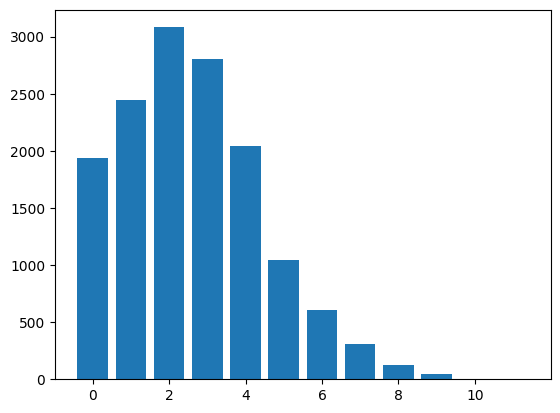

In [47]:
plt.bar(proposal_gt_bins.keys(), proposal_gt_bins.values())
plt.show()

However, the number of proposals with same label as the coverage box (i.e. proposal with maximum iou wrt target box) follows a very different distribution: more than one proposal with same label as the coverage box is very rare.

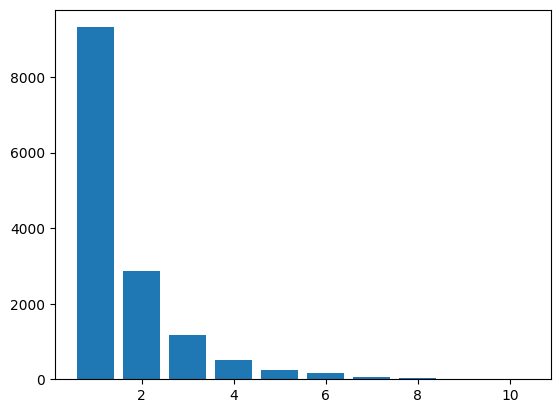

In [36]:
proposals_with_gt_label = dsort(proposals_with_gt_label, reverse=False)

plt.bar(proposals_with_gt_label.keys(), proposals_with_gt_label.values())
plt.show()

In [37]:
print("1 proposal with same label as cov box =", list(proposals_with_gt_label.values())[0] / sum(list(proposals_with_gt_label.values())))
print("2 proposal with same label as cov box =", list(proposals_with_gt_label.values())[1] / sum(list(proposals_with_gt_label.values())))
print("3 proposal with same label as cov box =", list(proposals_with_gt_label.values())[2] / sum(list(proposals_with_gt_label.values())))

1 proposal with same label as cov box = 0.6457423958982886
2 proposal with same label as cov box = 0.19794914432203978
3 proposal with same label as cov box = 0.08189565578881729


When the model fails most? The model fails aligning the proposal or fails to disambiguate between different proposals?

The following chart shows the percentage of fails per number of proposals that overlap with ground truth. As we can see, obviously we have 100% error when no proposals overlap ground truth, but we have also a large number of failures where there is only one proposal.

<BarContainer object of 12 artists>

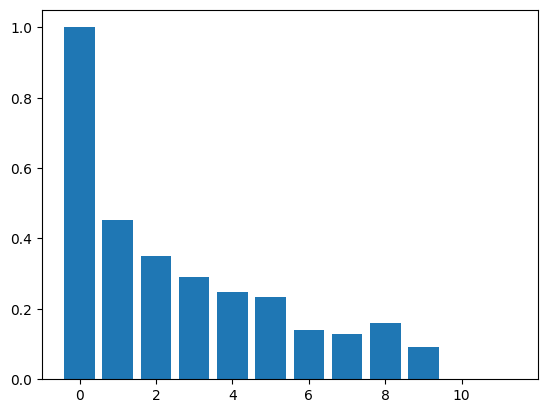

In [53]:
x = [1 - (x / y) for x, y in zip(predictions_per_overlaps.values(), proposal_gt_bins.values())]
plt.bar(predictions_per_overlaps.keys(), x)

In absolute terms, with 1 overlap we have

In [55]:
print("failures =", proposal_gt_bins[1] - predictions_per_overlaps[1])
print("failures =", 1 - (predictions_per_overlaps[1] / proposal_gt_bins[1]))

failures = 1106
failures = 0.4523517382413088


The following chart shows absolute values for the previous chart.

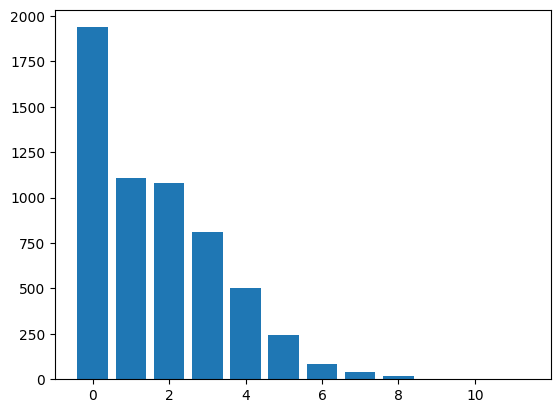

In [46]:
fail_bins = dsort(predictions_per_overlaps, reverse=False).copy()
fail_bins = {k: proposal_gt_bins[k] - v for k, v in fail_bins.items()}

plt.bar(fail_bins.keys(), fail_bins.values())
plt.show()

Please note that no coverage impacts a lot on failures:

In [60]:
print("0 cov failures =", fail_bins[0])
print("other = ", sum(list(fail_bins.values())[1:]))
print("0 cov failures % = ", fail_bins[0] / sum(list(fail_bins.values())[1:]))

0 cov failures = 1938
other =  3889
0 cov failures % =  0.4983286191823091


The chart below shows failures per class.

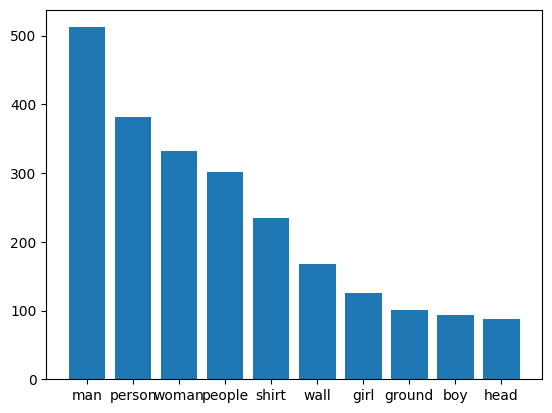

In [80]:
failed_per_class = dsort(failed_per_class, by="value", reverse=True)
failed_per_class = dslice(failed_per_class, 10)

plt.bar(failed_per_class.keys(), failed_per_class.values())
plt.show()

Then, we can see class by class how the number of cov proposals impacts on results:

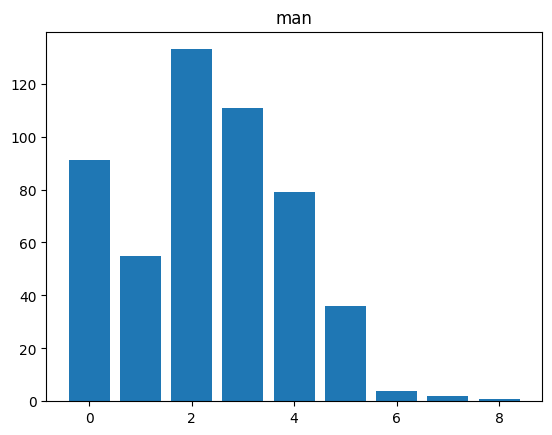

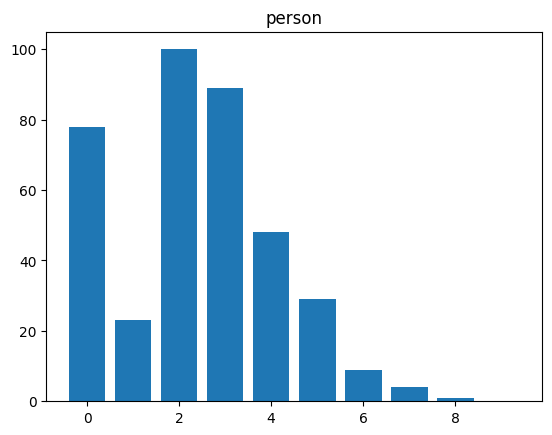

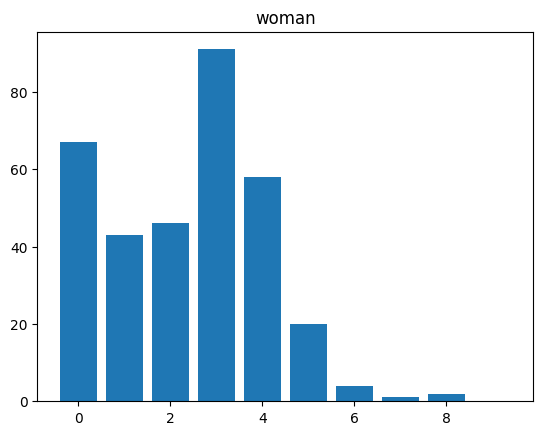

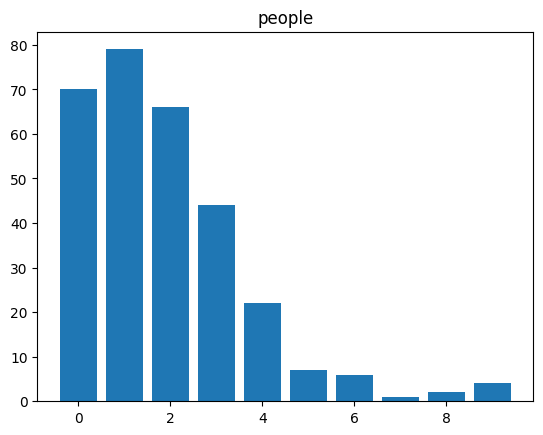

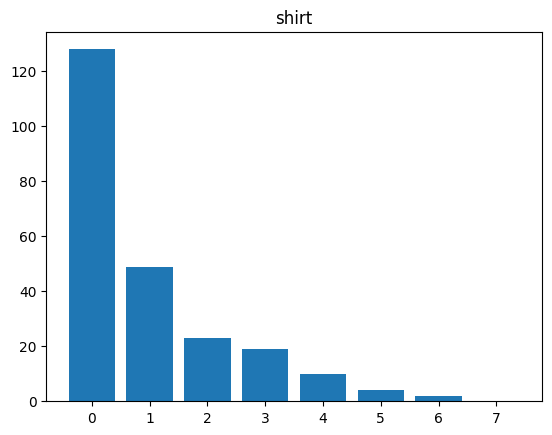

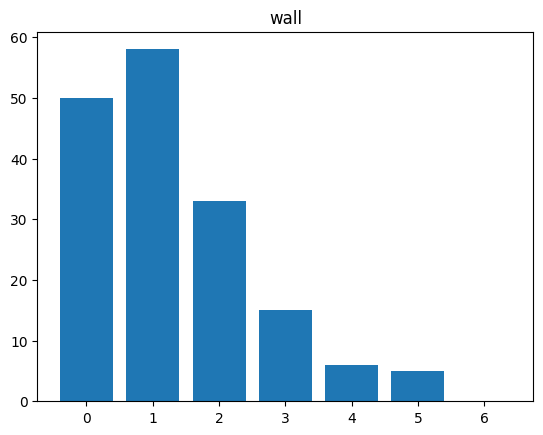

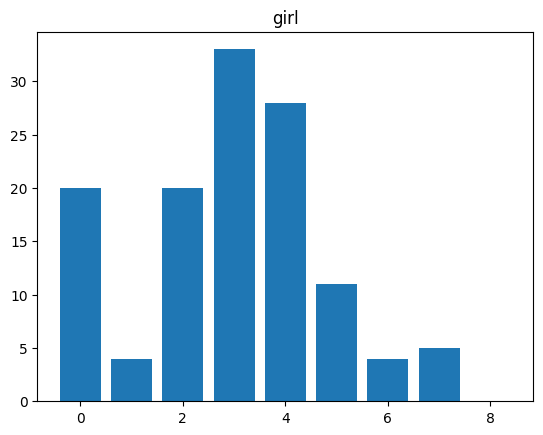

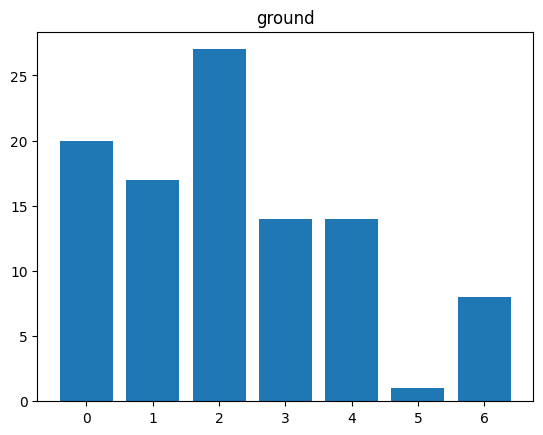

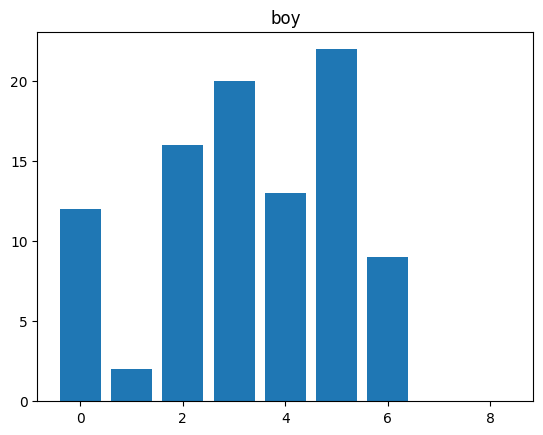

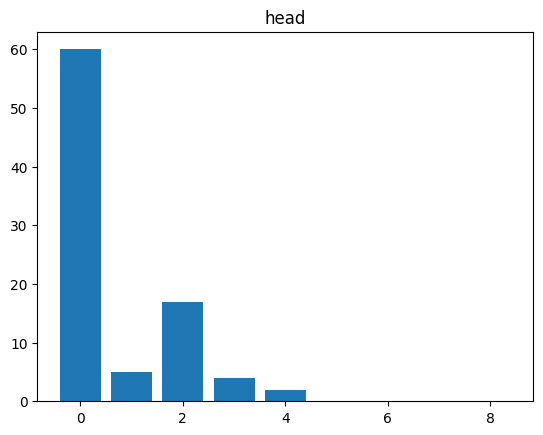

In [83]:
for k in list(failed_per_class.keys()):
  plt.bar(failed_per_class_per_overlap[k].keys(), failed_per_class_per_overlap[k].values())
  plt.title(k)
  plt.show()

---

Number of proposals with same label as the coverage box overlapping with gt

<BarContainer object of 3 artists>

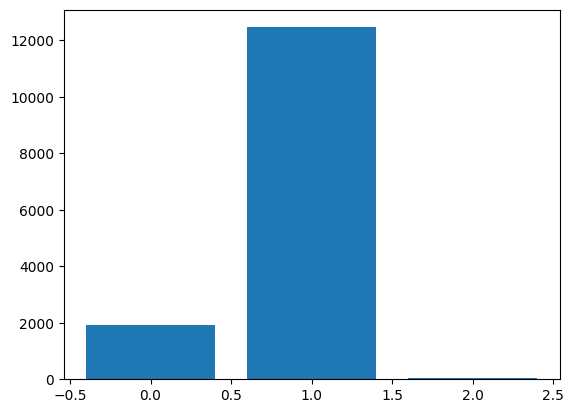

In [40]:
plt.bar(proposals_with_gt_label_overlapping.keys(), proposals_with_gt_label_overlapping.values())

In [41]:
print(dict(sorted(proposals_with_gt_label.items())))
print(dict(sorted(proposals_with_gt_label_overlapping.items())))

print(sum(proposals_with_gt_label.values()))
print(sum(proposals_with_gt_label_overlapping.values()))

{1: 9320, 2: 2857, 3: 1182, 4: 517, 5: 251, 6: 169, 7: 55, 8: 47, 9: 17, 10: 18}
{0: 1938, 1: 12462, 2: 33}
14433
14433


In [42]:
d = proposals_with_gt_label.copy()

d[1] / n_queries

0.6457423958982886

In [43]:
list(cls_bins.keys())

bins_count = {k: sum(cls_bins[k].values()) for k in cls_bins}
bins_ordered = {k: v for k, v in sorted(bins_count.items(), key=lambda item: item[1], reverse=True)}
bins_20 = {k: bins_ordered[k] for k in list(bins_ordered.keys())[0:20]}
bins_20

{'man': 4723,
 'person': 3454,
 'woman': 3074,
 'people': 1972,
 'girl': 1778,
 'boy': 1697,
 'shirt': 1535,
 'child': 660,
 'jacket': 562,
 'dog': 545,
 'ground': 521,
 'wall': 401,
 'building': 376,
 'men': 327,
 'chair': 323,
 'dress': 295,
 'grass': 289,
 'water': 275,
 'suit': 256,
 'coat': 250}

In [44]:
def f(k):
  d = cls_bins[k]
  d_ordered = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}
  d_20 = {k: d_ordered[k] for k in list(d_ordered.keys())[0:20]}
  
  plt.bar(d_20.keys(), d_20.values(), label=k)
  plt.title(k)
  plt.xticks(rotation=45)
  plt.show()

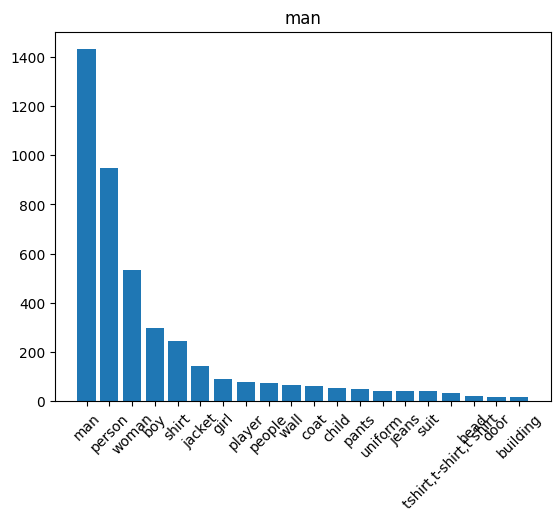

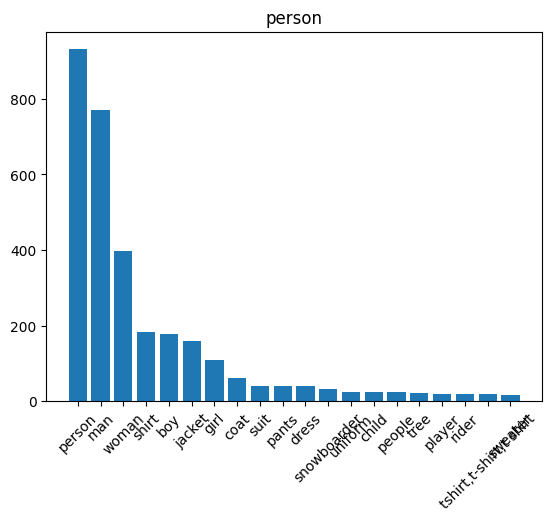

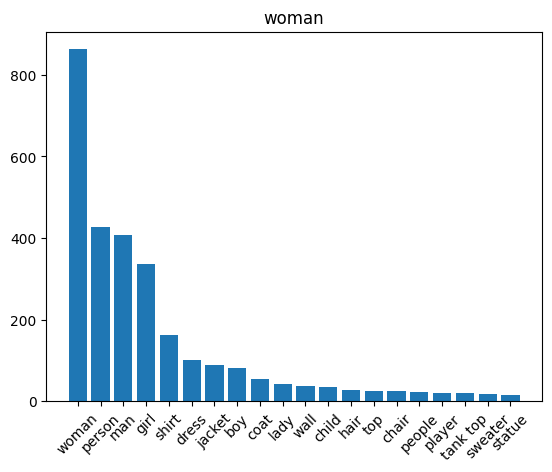

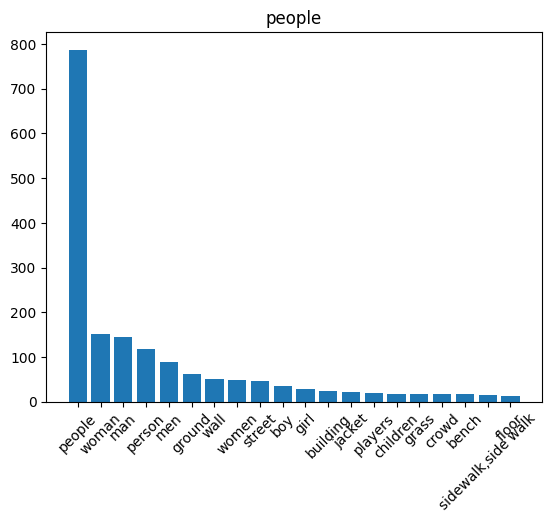

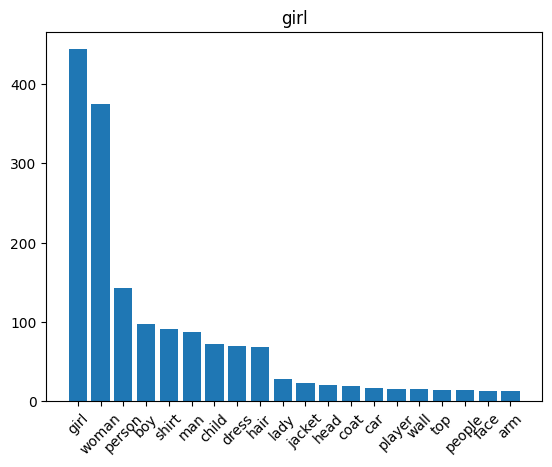

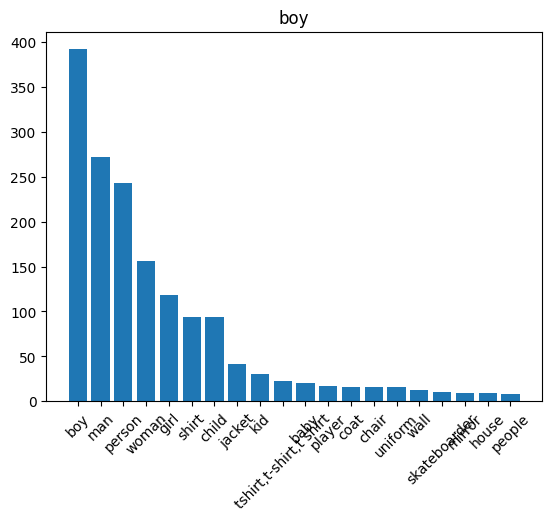

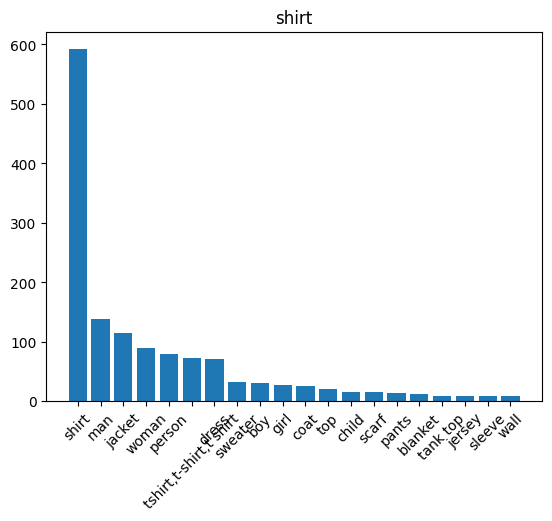

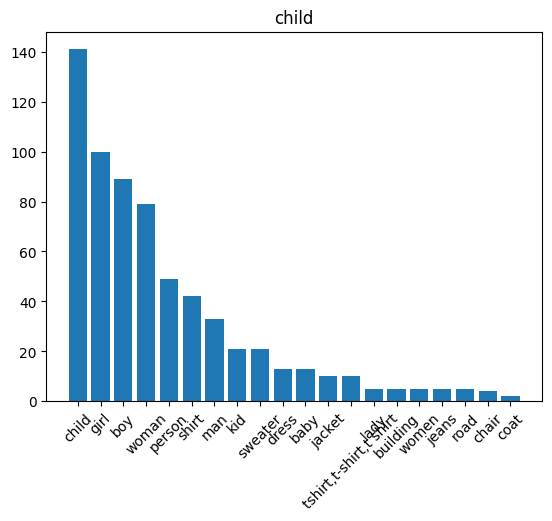

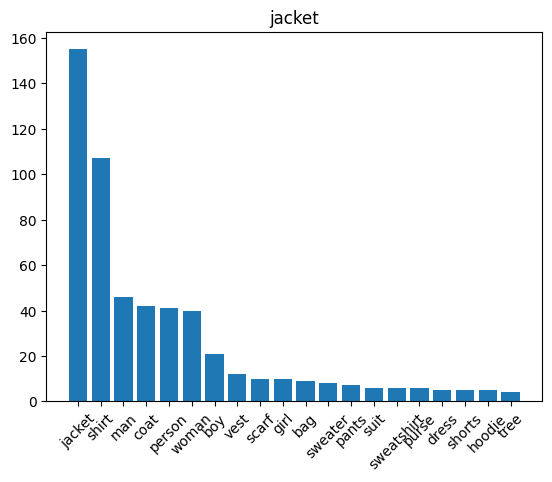

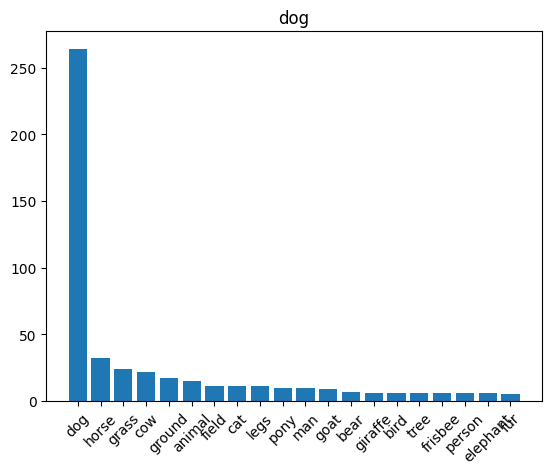

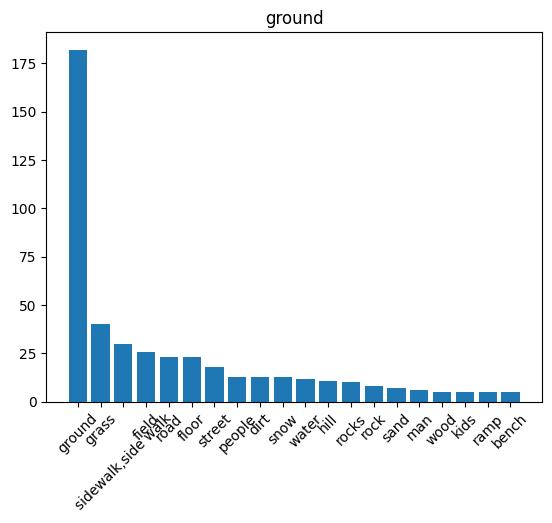

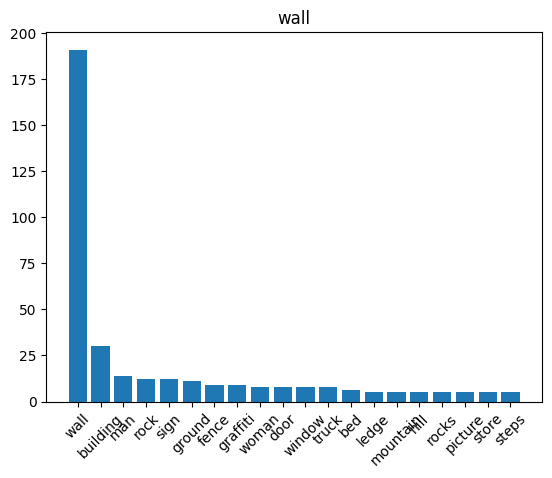

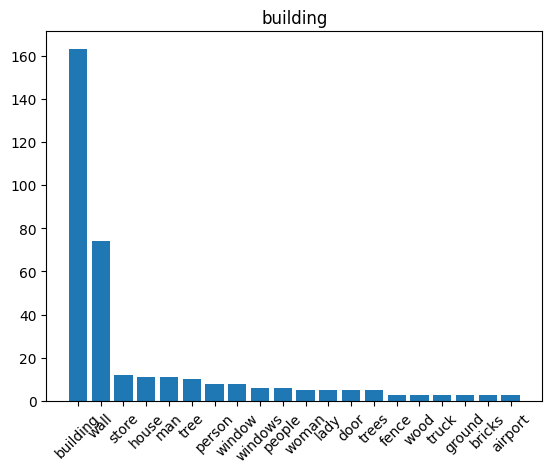

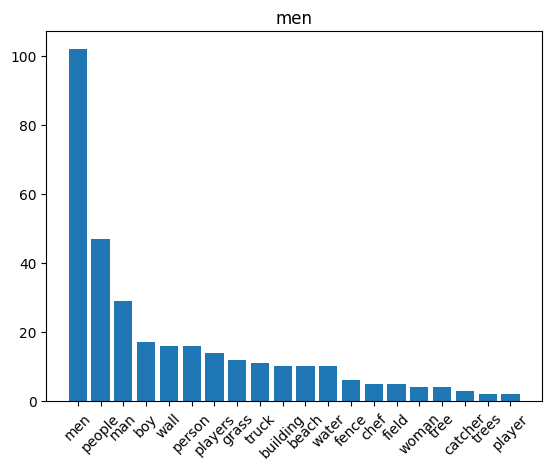

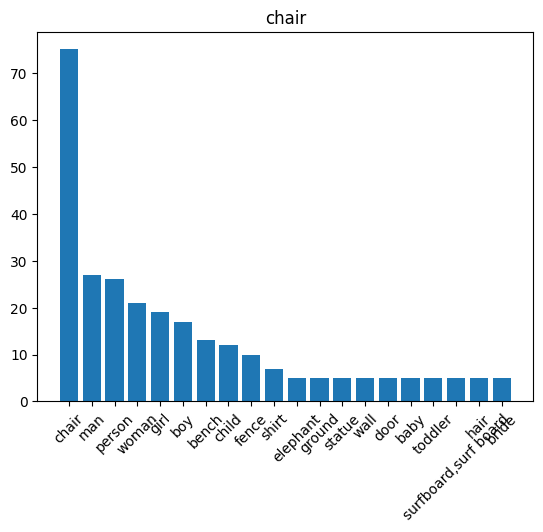

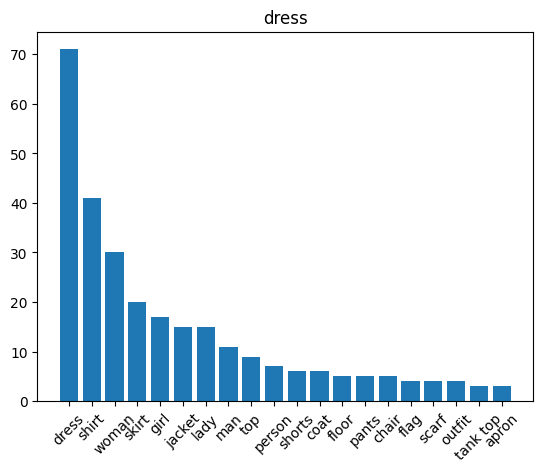

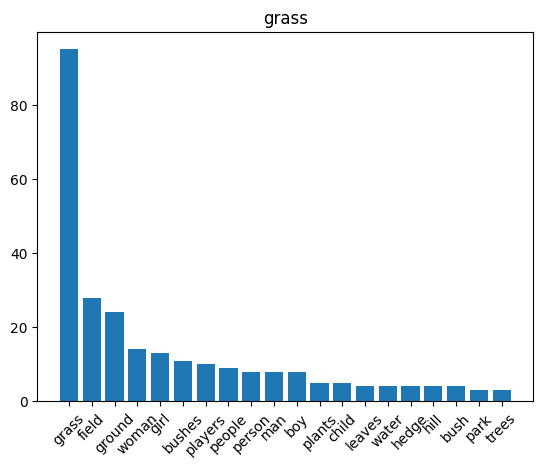

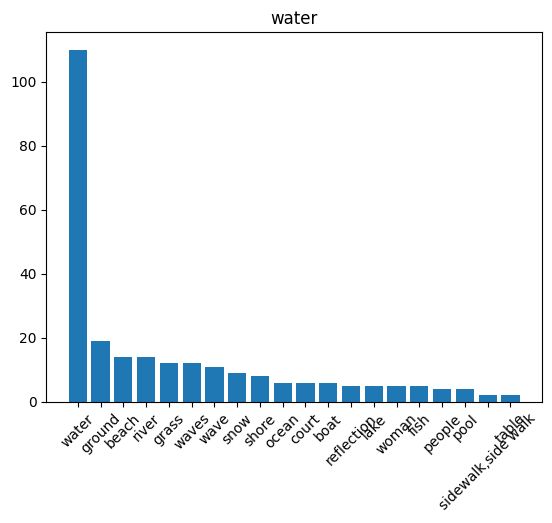

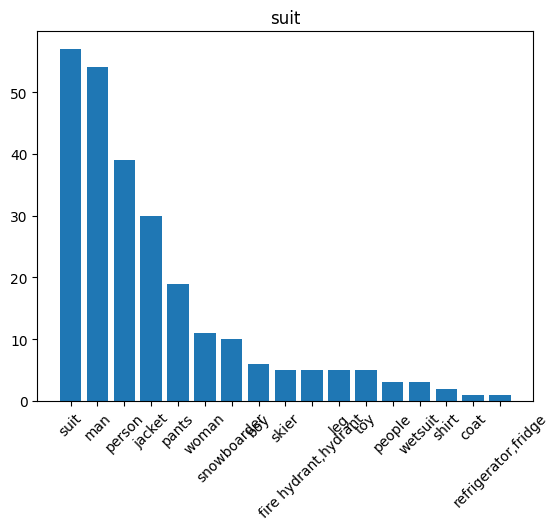

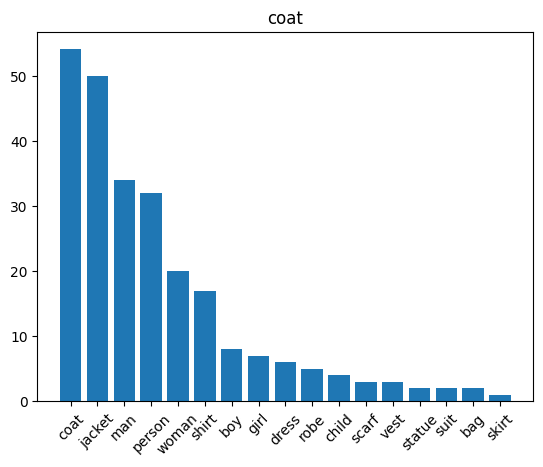

In [45]:
for k in list(bins_20.keys()):
  f(k)